In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [96]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

847
(847, 264, 124)


In [97]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83
N = X[0].shape[0]

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [tr/20*N, 0.8*N], 2*N)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

def flat_fc_to_mat(fc, nroi):
    p = np.zeros((nroi,nroi))
    a,b = np.triu_indices(nroi, 1)
    p[a,b] = fc
    p = p+p.T
    return p

ps = [np.stack([ts_to_flat_fc(ts/np.linalg.norm(ts, axis=-1, keepdims=True)) for ts in filter_design_ts(Xp)]) for Xp in X]
print(ps[0].shape)
# ts = [np.stack([ts for ts in filter_design_ts(Xp)]) for Xp in X]
# ts = [tsmod/np.linalg.norm(tsmod, axis=-1, keepdims=True) for tsmod in ts]
# print(ts[0].shape)

(847, 34716)


In [83]:
from math import sqrt
import scipy.stats

thresh = 0.05/34716
t = 0.4*sqrt(122)/(sqrt(1-0.4**2))
p = scipy.stats.t.sf(abs(t), df=34716)*2
print(thresh)
print(p)

1.4402580942504897e-06
1.4373848547595792e-06


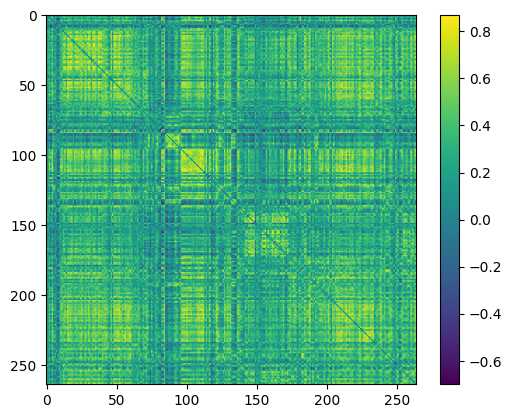

In [98]:
import matplotlib.pyplot as plt

# fcvar = np.var(ps, axis=0)
plt.imshow(flat_fc_to_mat(ps[0][1], 264))
plt.colorbar()
plt.show()

In [88]:
psc = np.stack([p*(np.abs(p)>0.1) for p in ps])
print(psc.shape)

(847, 34716)


In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F

mseLoss = nn.MSELoss()

yhats = []
losses = []
for i in range(3):
    ntrain = 30
    x = torch.from_numpy(ps[i]).float().cuda()
    xtr = x[:ntrain]
    xt = x[ntrain:]

    y = get_y(metadict, ['age'], subs)[0]
    y_t = torch.from_numpy(y).float().cuda()
    ytr = y_t[:ntrain]
    yt = y_t[ntrain:]

    w, _, _, _ = torch.linalg.lstsq(xtr, ytr)

    print(mseLoss(xtr@w, ytr)**0.5)
    loss = mseLoss(xt@w, yt)**0.5
    print(loss)
    yhats.append(xt@w)
    losses.append(loss)
    
print([float(l) for l in losses] + [float(mseLoss(sum(yhats)/3, yt)**0.5)])

tensor(3.3575e-05, device='cuda:0')
tensor(44.8163, device='cuda:0')
tensor(3.1395e-05, device='cuda:0')
tensor(40.1524, device='cuda:0')
tensor(2.9085e-05, device='cuda:0')
tensor(43.2441, device='cuda:0')
[44.816253662109375, 40.15238952636719, 43.244056701660156, 39.118255615234375]


In [4]:
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self, nt):
        super(AE, self).__init__()
        self.e1 = nn.Linear(nt,500).float().cuda()
        self.e2 = nn.Linear(500,500).float().cuda()
        self.e3 = nn.Linear(500,2000).float().cuda()
        self.e4 = nn.Linear(2000,10).float().cuda()
        self.d1 = nn.Linear(10,2000).float().cuda()
        self.d2 = nn.Linear(2000,500).float().cuda()
        self.d3 = nn.Linear(500,500).float().cuda()
        self.d4 = nn.Linear(500,nt).float().cuda()
        self.encoders = [self.e1, self.e2, self.e3, self.e4]
        self.decoders = [self.d1, self.d2, self.d3, self.d4]
        
    def forward(self, ts):
        x = ts
        for e in self.encoders:
            x = F.relu(e(x))
        for d in self.decoders:
            if d == self.d4:
                x = d(x)
            else:
                x = F.relu(d(x))
        return x

nEpochs = 2000
pPeriod = 100

x = torch.from_numpy(ts[0]).float().cuda()

mseLoss = nn.MSELoss()
ae = AE(x.shape[-1])

optim = torch.optim.Adam(ae.parameters(), lr=2e-4, weight_decay=1e-7)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.9, eps=1e-7)
    
newts = []
    
for sub in range(x.shape[0]):
    for epoch in range(nEpochs):
        optim.zero_grad()
        xhat = ae(x[sub])
        loss = mseLoss(xhat, x[sub])
        loss.backward()
        optim.step()
        sched.step(loss)
        if epoch == nEpochs-1:
            newts.append(xhat.detach().clone())
            print(f'{sub} {epoch} recon: {loss**0.5} lr: {sched._last_lr}')

print('Complete')

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

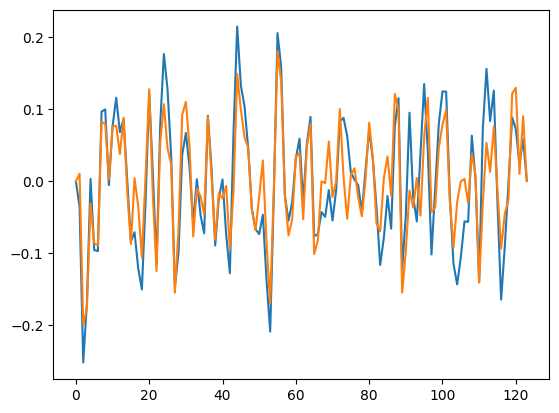

In [12]:
import matplotlib.pyplot as plt

plt.plot(ts[0][2,0])
plt.plot(ts[0][2,0]-newtsnp[2,0])
plt.show()

In [71]:
newtsnp = torch.stack(newts).detach().cpu().numpy()
print(newtsnp.shape)

(847, 264, 124)


In [2]:
import pickle

newtsnp = None

with open('../../Work/BadAutoencoder/restbadauto_goodrecon.pkl', 'rb') as f:
#     pickle.dump(newtsnp, f)
    newtsnp = pickle.load(f)
    
print('Complete')

Complete


In [13]:
res = x-torch.from_numpy(newtsnp).float().cuda()
print(res.shape)

torch.Size([847, 264, 124])


In [87]:
ntrain = 500

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y).float().cuda()
ytr = y_t[40:ntrain]
yt = y_t[ntrain:]

xr = [ts_to_flat_fc(res[i].detach().cpu().numpy()) for i in range(res.shape[0])]
xr = np.stack(xr)
xr = torch.from_numpy(xr).reshape(res.shape[0],-1).float().cuda()
xrtr = xr[40:ntrain]
xrt = xr[ntrain:]

xog = [ts_to_flat_fc(x[i].detach().cpu().numpy()) for i in range(x.shape[0])]
xog = np.stack(xog)
xog = torch.from_numpy(xog).reshape(xog.shape[0],-1).float().cuda()
xogtr = xog[40:ntrain]
xogt = xog[ntrain:]

print(xr.shape)
print(xog.shape)

torch.Size([847, 34716])
torch.Size([847, 34716])


In [90]:
from ksvd import ApproximateKSVD

aksvd = ApproximateKSVD(n_components=1000, transform_n_nonzero_coefs=1000, max_iter=2)
dictionary = aksvd.fit(xr.detach().cpu().numpy()).components_
gamma = aksvd.transform(xr.detach().cpu().numpy())

print(dictionary.shape)
print(gamma.shape)

(1000, 34716)
(847, 1000)


In [91]:
xrtr = torch.from_numpy(gamma[40:500]).float().cuda()
xrt = torch.from_numpy(gamma[500:]).float().cuda()

In [92]:
w1, _, _, _ = torch.linalg.lstsq(xrtr, ytr)
w2, _, _, _ = torch.linalg.lstsq(xogtr, ytr)

print(mseLoss(xrtr@w1, ytr)**0.5)
print(mseLoss(xrt@w1, yt)**0.5)
print(mseLoss(xogtr@w2, ytr)**0.5)
print(mseLoss(xogt@w2, yt)**0.5)

tensor(6.2555e-05, device='cuda:0')
tensor(41.2729, device='cuda:0')
tensor(0.0001, device='cuda:0')
tensor(30.5817, device='cuda:0')


In [94]:
import pickle

with open('../../Work/BadAutoencoder/ksvd_rest_1000_2.pkl', 'wb') as f:
    pickle.dump({'dict': dictionary, 'gamma': gamma}, f)
    
print('Complete')

Complete


In [417]:
yhats = []

In [418]:
yhats.append(yhat)
print(len(yhats))

1


In [412]:
print(mseLoss(sum(yhats)/3, yt)**0.5)

tensor(26.4708, device='cuda:0', grad_fn=<PowBackward0>)


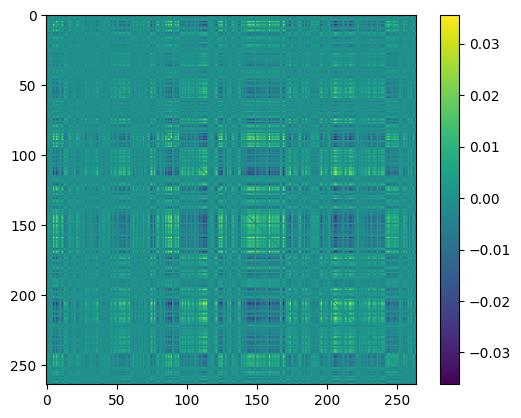

In [103]:
import matplotlib.pyplot as plt

plt.imshow(xsub[:,:,39].detach().cpu().numpy())
plt.colorbar()
plt.show()

In [12]:
torch.linalg.norm(torch.Tensor([[1,2,3],[3,4,5]]), dim=0, keepdims=True)

tensor([[3.1623, 4.4721, 5.8310]])

In [84]:
torch.where(torch.max(tstr_out[:,0,30], dim=1).values > 50)

(tensor([ 17,  83,  97, 122, 132, 162, 169, 195, 198, 200, 208, 223, 238, 248,
         286, 289, 290, 333, 350, 434, 453, 489, 546, 614, 616, 631, 641, 705,
         716, 725, 777, 810], device='cuda:0'),)

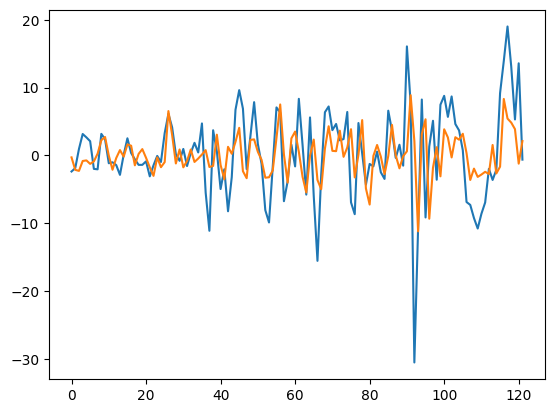

In [236]:
import matplotlib.pyplot as plt

plt.plot(tstr_out[10,0,30].detach().cpu().numpy())
plt.plot(xhat[10,30].detach().cpu().numpy())
plt.show()

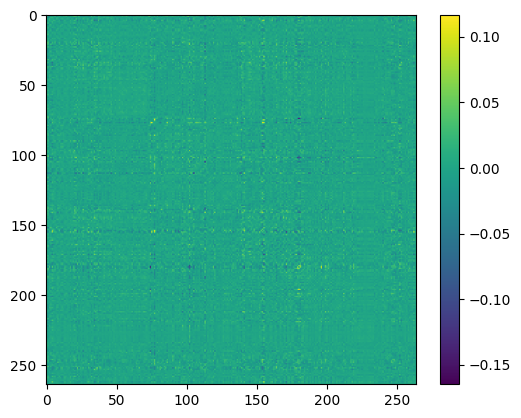

In [237]:
# Examine codebook

plt.imshow(book[10].detach().cpu().numpy())
plt.colorbar()
plt.show()

In [238]:
# Estimate weights

nEpochs = 500
pPeriod = 100

book = lrc().detach().clone()
book.grad = None

lrw2 = LowRankWeights(tstr_in.shape[0], tstr_out.shape[1], nCodes, nw)
optim = torch.optim.Adam(lrw2.parameters(), lr=1e-1, weight_decay=0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    for i in range(1):
        optim.zero_grad()
        xhat = lrw2(tstr_in[:,i], book, i)
        xloss = mseLoss(xhat, tstr_out[:,i])
        xloss.backward()
        optim.step()
        sched.step(xloss)
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'{epoch} recon: {float(xloss**0.5)} lr: {float(sched._last_lr[0])}')

print('Complete')

0 recon: 97.65791320800781 lr: 0.1
100 recon: 6.755094051361084 lr: 0.08145062499999998
200 recon: 6.443493843078613 lr: 0.08145062499999998
300 recon: 6.369539737701416 lr: 0.08145062499999998
400 recon: 6.343796253204346 lr: 0.08145062499999998
499 recon: 6.331742286682129 lr: 0.08145062499999998
Complete


In [239]:
import torch
import torch.nn as nn
import torch.nn.functional as F

xec = lrw2.w[:,0].reshape(lrw2.w.shape[0],-1)
xectr = xec[:600]
xect = xec[600:]

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y).float().cuda()
ytr = y_t[:600]
yt = y_t[600:]

print(xec.shape)
print(xectr.shape)
print(xect.shape)
print(y.shape)

torch.Size([847, 200])
torch.Size([600, 200])
torch.Size([247, 200])
(847,)


In [240]:
mseLoss = nn.MSELoss()

w, _, _, _ = torch.linalg.lstsq(xectr, ytr)
yhattr = xectr@w
yhatt = xect@w
print(mseLoss(yhattr, ytr)**0.5)
print(mseLoss(yhatt, yt)**0.5)

tensor(29.0802, device='cuda:0', grad_fn=<PowBackward0>)
tensor(45.0205, device='cuda:0', grad_fn=<PowBackward0>)


In [241]:
class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(dim,30).float().cuda()
        self.l1 = nn.Linear(30,1).float().cuda()
        
    def forward(self, x):
        y = F.relu(self.l0(x))
        y = self.l1(y).squeeze()
        return y

mseLoss = nn.MSELoss()
    
mlp = MLP(xec.shape[1])
optim = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e0)

nEpochs = 10000
pPeriod = 1000

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = mlp(xectr)
    loss = mseLoss(yhat, ytr)
#     l1loss = 1e0*(torch.sum(torch.abs(mlp.l0.weight))+torch.sum(torch.abs(mlp.l0.bias)))
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')
print(mseLoss(mlp(xect), yt)**0.5)

0 184.54291082970377 lr: [0.001]
1000 75.82232778426814 lr: [0.001]
2000 37.87341909602878 lr: [0.001]
3000 31.338012778762394 lr: [0.001]
4000 28.669798332492352 lr: [0.001]
5000 27.28739617013858 lr: [0.001]
6000 26.43929492096884 lr: [0.001]
7000 25.86838140932442 lr: [0.001]
8000 25.41327955679926 lr: [0.001]
9000 25.118618738382466 lr: [0.001]
9999 24.979149019576056 lr: [0.0003584859224085418]
Complete
tensor(36.4105, device='cuda:0', grad_fn=<PowBackward0>)


In [242]:
import sys 

sys.path.append('../../LatentSimilarity')

from latsim import LatSim

print('Complete')

Complete


In [244]:
sim = LatSim(1, xec.unsqueeze(1), dp=0.5, edp=0, wInit=1e-4, dim=10, temp=10)
optim = torch.optim.Adam(sim.parameters(), lr=1e-3, weight_decay=1e-3)

nEpochs = 1000
pPeriod = 100

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = sim(xectr.unsqueeze(1), [ytr])[0][0]
    loss = mseLoss(yhat, ytr)
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')

print(mseLoss(sim(xec.unsqueeze(1), [y_t], torch.arange(600,y_t.shape[0]))[0][0][600:], yt)**0.5)

0 40.081035164810956 lr: [0.001]
100 39.012242669769705 lr: [0.001]
200 36.265906060414544 lr: [0.00095]
300 35.12271664620172 lr: [0.0006983372960937497]
400 34.958090840810726 lr: [0.00046329123015975297]
500 34.14083595472583 lr: [0.00030735686772502346]
600 33.62322471498495 lr: [0.00021463876394293716]
700 33.7593809300652 lr: [0.00014239574134637458]
800 34.44626667849417 lr: [8.974483193085068e-05]
900 34.228330565209426 lr: [5.373354598274025e-05]
999 34.26560540640115 lr: [3.3865535638032174e-05]
Complete
tensor(37.0512, device='cuda:0', grad_fn=<PowBackward0>)
